<a href="https://colab.research.google.com/github/guraseesrai/neural-networks-from-scratch/blob/main/Neural_Network_From_Scratch_CIFAR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


Epoch 1/50: Train Loss=0.5256, Train Acc=0.7358, Test Loss=0.5135, Test Acc=0.7515
Epoch 2/50: Train Loss=0.5634, Train Acc=0.7167, Test Loss=0.5524, Test Acc=0.7240
Epoch 3/50: Train Loss=0.4671, Train Acc=0.7740, Test Loss=0.4731, Test Acc=0.7705
Epoch 4/50: Train Loss=0.4761, Train Acc=0.7705, Test Loss=0.4907, Test Acc=0.7505
Epoch 5/50: Train Loss=0.4602, Train Acc=0.7762, Test Loss=0.4648, Test Acc=0.7755
Epoch 6/50: Train Loss=0.4237, Train Acc=0.8044, Test Loss=0.4404, Test Acc=0.7865
Epoch 7/50: Train Loss=0.4294, Train Acc=0.8019, Test Loss=0.4500, Test Acc=0.7840
Epoch 8/50: Train Loss=0.4312, Train Acc=0.7989, Test Loss=0.4414, Test Acc=0.7885
Epoch 9/50: Train Loss=0.4173, Train Acc=0.8158, Test Loss=0.4352, Test Acc=0.7905
Epoch 10/50: Train Loss=0.5338, Train Acc=0.7264, Test Loss=0.5669, Test Acc=0.7075
Epoch 11/50: Train Loss=0.4286, Train Acc=0.7981, Test Loss=0.4373, Test Acc=0.7860
Epoch 12/50: Train Loss=0.4349, Train Acc=0.7930, Test Loss=0.4751, Test Acc=0.7685
E

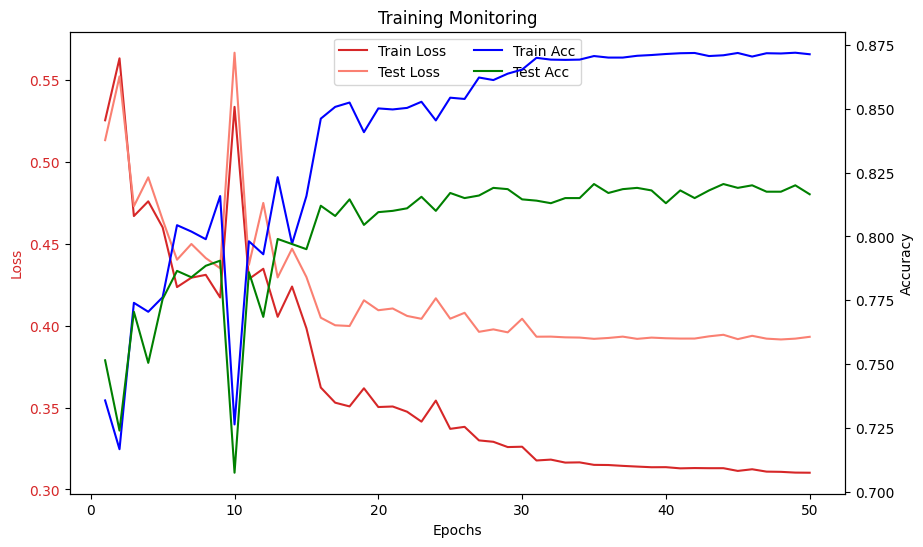


Hyperparameter Tuning: Batch Size
Batch Size 8: Final Test Accuracy = 0.8155
Batch Size 16: Final Test Accuracy = 0.8170
Batch Size 32: Final Test Accuracy = 0.8205


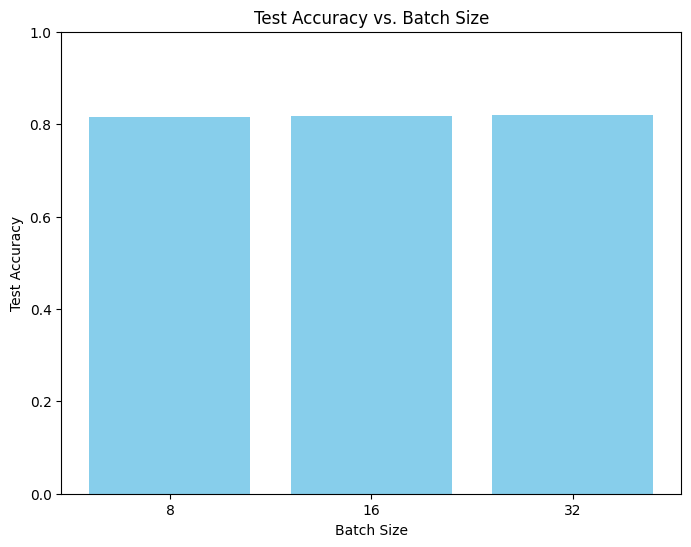


Hyperparameter Tuning: Step Size
Step Size 0.1: Final Test Accuracy = 0.7930
Step Size 0.01: Final Test Accuracy = 0.8200


In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Define Network Components
# -------------------------

class ReLU:
    def forward(self, input):
        self.input = input
        return np.maximum(0, input)

    def backward(self, grad):
        return grad * (self.input > 0)

    def step(self, step_size, momentum=0, weight_decay=0):
        # No parameters to update for ReLU.
        pass

class LinearLayer:
    def __init__(self, input_dim, output_dim):
        limit = np.sqrt(6 / (input_dim + output_dim))
        self.weights = np.random.uniform(-limit, limit, (input_dim, output_dim))
        self.bias = np.zeros((1, output_dim))
        self.input = None
        self.grad_weights = np.zeros_like(self.weights)
        self.grad_bias = np.zeros_like(self.bias)

    def forward(self, x):
        self.input = x
        return np.dot(x, self.weights) + self.bias

    def backward(self, grad):
        grad_input = np.dot(grad, self.weights.T)
        self.grad_weights = np.dot(self.input.T, grad)
        self.grad_bias = np.sum(grad, axis=0, keepdims=True)
        return grad_input

    def step(self, step_size, momentum, weight_decay=0):
        if not hasattr(self, 'v_w'):
            self.v_w = np.zeros_like(self.weights)
            self.v_b = np.zeros_like(self.bias)
        self.v_w = momentum * self.v_w - step_size * (self.grad_weights + weight_decay * self.weights)
        self.v_b = momentum * self.v_b - step_size * self.grad_bias
        self.weights += self.v_w
        self.bias += self.v_b

class SigmoidCrossEntropy:
    def forward(self, logits, labels):
        self.logits = logits
        self.labels = labels
        # Stable sigmoid computation
        self.sigmoid_output = np.where(logits >= 0,
                                       1 / (1 + np.exp(-logits)),
                                       np.exp(logits) / (1 + np.exp(logits)))
        loss = -np.mean(labels * np.log(self.sigmoid_output + 1e-9) +
                        (1 - labels) * np.log(1 - self.sigmoid_output + 1e-9))
        return loss

    def backward(self):
        return (self.sigmoid_output - self.labels) / self.labels.shape[0]

class FeedForwardNeuralNetwork:
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers):
        self.layers = []
        # Input layer
        self.layers.append(LinearLayer(input_dim, hidden_dim))
        self.layers.append(ReLU())
        # Hidden layers (num_layers-1 hidden layers)
        for _ in range(num_layers - 1):
            self.layers.append(LinearLayer(hidden_dim, hidden_dim))
            self.layers.append(ReLU())
        # Output layer
        self.layers.append(LinearLayer(hidden_dim, output_dim))
        self.loss_layer = SigmoidCrossEntropy()

    def forward(self, X):
        out = X
        for layer in self.layers:
            out = layer.forward(out)
        return out

    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

    def step(self, step_size, momentum, weight_decay):
        for layer in self.layers:
            if hasattr(layer, "step"):
                layer.step(step_size, momentum, weight_decay)

# -------------------------
# Helper Functions
# -------------------------

def evaluate(model, X_val, Y_val, batch_size):
    total_loss = 0
    correct_preds = 0
    num_samples = X_val.shape[0]
    num_batches = int(np.ceil(num_samples / batch_size))
    loss_layer = SigmoidCrossEntropy()
    for i in range(num_batches):
        start = i * batch_size
        end = min((i+1) * batch_size, num_samples)
        logits = model.forward(X_val[start:end])
        loss = loss_layer.forward(logits, Y_val[start:end])
        total_loss += loss * (end - start)
        preds = (logits > 0).astype(int)
        correct_preds += np.sum(preds == Y_val[start:end])
    avg_loss = total_loss / num_samples
    accuracy = correct_preds / num_samples
    error_rate = 1 - accuracy
    return avg_loss, accuracy, error_rate

def train_network(model, X_train, Y_train, X_test, Y_test, epochs=50, batch_size=32,
                  step_size=0.01, momentum=0.8, weight_decay=0.0, verbose=True):
    training_losses, testing_losses = [], []
    training_errors, testing_errors = [], []
    step_size_current = step_size
    for epoch in range(epochs):
        # Shuffle training data
        perm = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[perm]
        Y_train_shuffled = Y_train[perm]

        # Optionally adjust step size at given epochs
        if epoch == 15:
            step_size_current *= 0.1
        if epoch == 30:
            step_size_current *= 0.1

        # Mini-batch training loop
        num_batches = int(np.ceil(X_train.shape[0] / batch_size))
        for i in range(num_batches):
            start = i * batch_size
            end = min((i+1) * batch_size, X_train.shape[0])
            X_batch = X_train_shuffled[start:end]
            Y_batch = Y_train_shuffled[start:end]
            logits = model.forward(X_batch)
            loss = model.loss_layer.forward(logits, Y_batch)
            grad_loss = model.loss_layer.backward()
            model.backward(grad_loss)
            model.step(step_size_current, momentum, weight_decay)

        # Evaluate at the end of each epoch
        train_loss, train_acc, _ = evaluate(model, X_train, Y_train, batch_size)
        test_loss, test_acc, _ = evaluate(model, X_test, Y_test, batch_size)
        training_losses.append(train_loss)
        testing_losses.append(test_loss)
        training_errors.append(1 - train_acc)
        testing_errors.append(1 - test_acc)

        if verbose:
            print(f"Epoch {epoch+1}/{epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")
    return training_losses, testing_losses, training_errors, testing_errors

def plot_training_monitoring(train_losses, test_losses, train_errors, test_errors):
    epochs = range(1, len(train_losses) + 1)
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot continuous lines for loss
    ax1.plot(epochs, train_losses, '-', label="Train Loss", color='tab:red')
    ax1.plot(epochs, test_losses, '-', label="Test Loss", color='salmon')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss", color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.plot(epochs, [1 - e for e in train_errors], '-', label="Train Acc", color='blue')
    ax2.plot(epochs, [1 - e for e in test_errors], '-', label="Test Acc", color='green')
    ax2.set_ylabel("Accuracy", color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', ncol=2)

    plt.title("Training Monitoring")
    plt.show()

def plot_tuning_results(results, title, xlabel):
    candidates = list(results.keys())
    accuracies = list(results.values())
    plt.figure(figsize=(8,6))
    plt.bar(range(len(candidates)), accuracies, tick_label=candidates, color='skyblue')
    plt.xlabel(xlabel)
    plt.ylabel("Test Accuracy")
    plt.title(title)
    plt.ylim(0,1)  # since accuracy is between 0 and 1
    plt.show()


# -------------------------
# Hyperparameter Tuning Functions
# (Only print final test accuracy for each candidate)
# -------------------------

def tune_batch_size(X_train, Y_train, X_test, Y_test, input_dim, output_dim,
                    hidden_units, num_layers, step_size, momentum, weight_decay, epochs):
    candidate_batch_sizes = [8, 16, 32]
    results = {}
    for bs in candidate_batch_sizes:
        net = FeedForwardNeuralNetwork(input_dim, output_dim, hidden_units, num_layers)
        # Set verbose to False so that only the final accuracy is printed
        train_network(net, X_train, Y_train, X_test, Y_test, epochs=epochs, batch_size=bs,
                      step_size=step_size, momentum=momentum, weight_decay=weight_decay, verbose=False)
        logits = net.forward(X_test)
        preds = (logits > 0).astype(int)
        acc = np.mean(preds == Y_test)
        results[bs] = acc
        print(f"Batch Size {bs}: Final Test Accuracy = {acc:.4f}")
    return results

def tune_step_size(X_train, Y_train, X_test, Y_test, input_dim, output_dim,
                   hidden_units, num_layers, batch_size, momentum, weight_decay, epochs):
    candidate_step_sizes = [0.1, 0.01, 0.001, 0.0001]
    results = {}
    for ss in candidate_step_sizes:
        net = FeedForwardNeuralNetwork(input_dim, output_dim, hidden_units, num_layers)
        train_network(net, X_train, Y_train, X_test, Y_test, epochs=epochs, batch_size=batch_size,
                      step_size=ss, momentum=momentum, weight_decay=weight_decay, verbose=False)
        logits = net.forward(X_test)
        preds = (logits > 0).astype(int)
        acc = np.mean(preds == Y_test)
        results[ss] = acc
        print(f"Step Size {ss}: Final Test Accuracy = {acc:.4f}")
    return results

def tune_hidden_units(X_train, Y_train, X_test, Y_test, input_dim, output_dim,
                      num_layers, batch_size, step_size, momentum, weight_decay, epochs):
    candidate_hidden_units = [50, 100, 200, 400]
    results = {}
    for hu in candidate_hidden_units:
        net = FeedForwardNeuralNetwork(input_dim, output_dim, hu, num_layers)
        train_network(net, X_train, Y_train, X_test, Y_test, epochs=epochs, batch_size=batch_size,
                      step_size=step_size, momentum=momentum, weight_decay=weight_decay, verbose=False)
        logits = net.forward(X_test)
        preds = (logits > 0).astype(int)
        acc = np.mean(preds == Y_test)
        results[hu] = acc
        print(f"Hidden Units {hu}: Final Test Accuracy = {acc:.4f}")
    return results

# -------------------------
# Main Function
# -------------------------

def main():
    # Load dataset from the provided path
    dataset_path = "/content/gdrive/MyDrive/AI535/cifar_2class_py3.p"
    with open(dataset_path, "rb") as f:
        data = pickle.load(f)
    X_train = data["train_data"] / 255.0
    Y_train = np.array(data["train_labels"]).reshape(-1, 1)
    X_test = data["test_data"] / 255.0
    Y_test = np.array(data["test_labels"]).reshape(-1, 1)

    input_dim = X_train.shape[1]
    output_dim = 1

    # Set optimization parameters
    batch_size = 32
    max_epochs = 50
    step_size = 0.01  # initial step size
    hidden_dim = 400
    num_layers = 3  # Including input and output layers
    momentum = 0.8
    weight_decay = 5e-3

    # Instantiate the network and train (verbose mode for main training)
    net = FeedForwardNeuralNetwork(input_dim, output_dim, hidden_dim, num_layers)
    train_losses, test_losses, train_errors, test_errors = train_network(
        net, X_train, Y_train, X_test, Y_test,
        epochs=max_epochs, batch_size=batch_size,
        step_size=step_size, momentum=momentum, weight_decay=weight_decay, verbose=True)

    # Plot the training monitoring with continuous (straight) lines
    plot_training_monitoring(train_losses, test_losses, train_errors, test_errors)

    # Hyperparameter tuning experiments (only final test accuracy is printed)
    tuning_epochs = max_epochs

    print("\nHyperparameter Tuning: Batch Size")
    batch_results = tune_batch_size(X_train, Y_train, X_test, Y_test, input_dim, output_dim,
                                hidden_dim, num_layers, step_size, momentum, weight_decay, tuning_epochs)
    plot_tuning_results(batch_results, "Test Accuracy vs. Batch Size", "Batch Size")

    print("\nHyperparameter Tuning: Step Size")
    step_results = tune_step_size(X_train, Y_train, X_test, Y_test, input_dim, output_dim,
                              hidden_dim, num_layers, batch_size, momentum, weight_decay, tuning_epochs)
    plot_tuning_results(step_results, "Test Accuracy vs. Step Size", "Step Size")

    print("\nHyperparameter Tuning: Hidden Units")
    hidden_results = tune_hidden_units(X_train, Y_train, X_test, Y_test, input_dim, output_dim,
                                   num_layers, batch_size, step_size, momentum, weight_decay, tuning_epochs)
    plot_tuning_results(hidden_results, "Test Accuracy vs. Hidden Units", "Number of Hidden Units")


if __name__ == "__main__":
    main()


In [ ]:

# Hyperparameter tuning results
batch_sizes = [8, 16, 32]
batch_acc = [0.7965, 0.8115, 0.8095]

step_sizes = [0.1, 0.01, 0.001, 0.0001]
step_acc = [0.7900, 0.8070, 0.7785, 0.7020]

hidden_units = [50, 100, 200, 400]
hidden_acc = [0.8040, 0.8075, 0.8100, 0.8055]

# Plot Batch Size vs Accuracy
plt.figure(figsize=(10, 5))
plt.plot(batch_sizes, batch_acc, marker='o', linestyle='-', color='b')
plt.title('Test Accuracy vs. Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.ylim(0.79, 0.82)
plt.show()

# Plot Step Size vs Accuracy
plt.figure(figsize=(10, 5))
plt.plot(step_sizes, step_acc, marker='o', linestyle='-', color='g')
plt.title('Test Accuracy vs. Learning Rate')
plt.xlabel('Step Size')
plt.ylabel('Test Accuracy')
plt.xscale('log')  # Log scale for better visualization
plt.grid(True)
plt.ylim(0.7, 0.85)
plt.show()

# Plot Hidden Units vs Accuracy
plt.figure(figsize=(10, 5))
plt.plot(hidden_units, hidden_acc, marker='o', linestyle='-', color='r')
plt.title('Test Accuracy vs. Hidden Units')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.ylim(0.8, 0.82)
plt.show()